# Logistic Matrix Factorization

## Problem Description

Binary matrices (Matrices with elements of 0/1) appear in many applications. A binary matrix can represent relations such as 'User $i$ bought item $j$', or 'Member $i$ likes Member $j$'. Such datasets are often sparse -- only a fraction of the possible entries of a matrix are known. 

A binary matrix can also viewed as the adjacency matrix of a bipartite graph. Hence each entry corresponds to an edge.
One task here is known as link prediction, meaning guessing the presence or absence of edges in the underlying graph. 
This prediction can then be used for several tasks such as recommendation or knowledge-base completion.

In this project, you are going to implement a matrix factorization with missing elements using Stochastic Gradient Descent (SGD), Batch SGD and GD first in numpy, then also making use of PyTorch. You will also analyze the effect of the fraction of missing elements, estimation rank and max iteration. 

The matrix you will factorize is a binary(logistic) matrix and has a specific pattern. Its elements that whose indices sum up to an even number are 1 and 0 otherwise. For more detailed derivation and problem description, you can analyze [this](https://github.com/atcemgil/notes/blob/master/Logistic%20Matrix%20Factorization.ipynb) notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [2]:
def sigmoid(t):
    return 1./(1+np.exp(-t))

def likelihood(XM, Mask, W, H):
    return np.sum(XM * np.dot(W, H) - Mask * np.log(1 + np.exp(np.dot(W, H))))

# Dataset Generation

This cell generates the dataset as we have discussed. It sets the elements whom indices sum up to even number to 1.

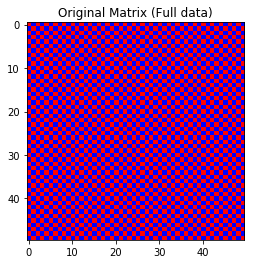

In [3]:
M = 50 # Use a square matrix of 50x50. You can change it if you wish
original_matrix = np.array([[int((i + j) % 2 == 0) for j in range(M)] for  i in range(M)])
plt.imshow(original_matrix, cmap='bwr')  
plt.title('Original Matrix (Full data)')
plt.show()

# Masking

Now mask the dataset. Number of elements to mask is set by a parameter. 

Seed the random for repeatability

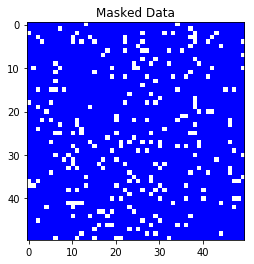

In [4]:
random.seed(10)
def generate_mask(M = 50, mask_count=M*M//10):
    masks = [(random.randint(0,M-1), random.randint(0,M-1)) for i in range(mask_count)]
    mask = np.ones((M,M))
    for m in masks:
        mask[m] = np.nan
    return mask

mask = generate_mask(M)
Mask = mask.copy()
Mask[mask != True] = False
plt.imshow(mask, cmap='bwr')  
plt.title('Masked Data')
plt.show()

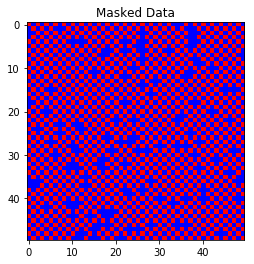

In [348]:
Y = original_matrix.copy()
Y[Mask==False] = 0
plt.imshow(Y, cmap='bwr')  
plt.title('Masked Data')
plt.show()

# Gradient Descents

Implement **SGD**. **BGD** and **GD** in this cell using **numpy**. Compute the error of the resulting matrix compared to original data for approximation ranks in [1,M]. For measuring the quality of the fit, you should use the log-likelihood

\begin{eqnarray}
\log p(Y |W, H ) &=& \sum_j \sum_{i} M(i,j) Y(i,j) \big(\sum_k W(i,k) H(k,j)\big)  - \sum_j \sum_{i} M(i,j) \log\bigg( 1+ \exp\big(\sum_k W(i,k) H(k,j)\big)\bigg) 
\end{eqnarray}

For plot generation, use results computed by SGD.

### Answer
$\newcommand{\trace}{\mathop{\text{Tr}}}$

\begin{eqnarray}
\frac{\partial}{\partial W(i,k)} \log p(Y |W, H ) &=& \sum_j M(i,j) Y(i,j) H(k,j)  - \sum_j M(i,j) \sigma\left(\sum_k W(i,k) H(k,j)\right) H(k, j) \\
&=& \sum_j M(i,j) \left(Y(i,j) - \sigma\left(\sum_k W(i,k) H(k,j)\right) \right) H(k, j)
\end{eqnarray}

\begin{eqnarray}
\frac{\partial}{\partial H(k,j)} \log p(Y |W, H ) &=& \sum_i M(i,j) Y(i,j) W(i,k)  - \sum_j M(i,j) \sigma\left(\sum_k W(i,k) H(k,j)\right) W(i, k) \\
&=& \sum_j M(i,j) \left(Y(i,j) - \sigma\left(\sum_k W(i,k) H(k,j)\right) \right) W(i, k)
\end{eqnarray}


#### Evaluating the gradient (In matrix notation)

$$
\frac{d\mathcal{L}(W,H)}{dW} = (M \odot (Y -\sigma(W H)))H^\top
$$

$$
\frac{d\mathcal{L}(W,H)}{dH} = W^\top (M \odot (Y -\sigma(W H)))
$$

In [363]:
# Implement SGD here. Add the method signatures for other gradient descents as well. You can add a batch size parameter to merge
# all types of gradient descents into one method.
def sgd(original_matrix, Mask, estimation_rank, BATCH_M, BATCH_N, MAX_ITER=10000, eta=0.005, nu=0.1):
    error_list = []
    XM = original_matrix.copy()
    XM[Mask==False] = 0

    M, N = original_matrix.shape
    K = estimation_rank
    W = np.random.randn(M,K)
    H = np.random.randn(K,N)
    
    for epoch in range(MAX_ITER):
        index0 = np.random.choice(M, BATCH_M, replace=False)
        index1 = np.random.choice(N, BATCH_N, replace=False)
        XM_1 = XM[index0,:]
        XM_F = XM_1[:,index1]
        Mask_1 = Mask[index0,:]
        Mask_F = Mask_1[:,index1]
        
        dLw = - np.dot(XM_F - Mask_F * sigmoid(np.dot(W[index0,:],H[:,index1])), H[:,index1].T) + nu * W[index0,:]
        W[index0,:] = W[index0,:] - eta * dLw
        dLh = - np.dot(W[index0,:].T, XM_F - Mask_F * sigmoid(np.dot(W[index0,:],H[:,index1]))) + nu * H[:,index1]
        H[:,index1] = H[:,index1] - eta * dLh

        if epoch > 5000:
            E = - likelihood(XM, Mask, W, H)
            error_list.append(E)
    error = - likelihood(XM, Mask, W, H)
    return W, H, error, error_list

In [356]:
M, N = original_matrix.shape
BATCH_M = 1
BATCH_N = N
if BATCH_M > M:
    BATCH_M = M
if BATCH_N > N:
    BATCH_N = N
# Compute error for varying estimation ranks from 1 to M
errors_list = []
errors = []
Ws = []
Hs = []
for rank in range(1, M + 1):
    W, H, error, error_list = sgd(original_matrix, Mask, rank, BATCH_M, BATCH_N, MAX_ITER=10000, eta=0.005, nu=0.1)
    errors_list.append(error_list)
    errors.append(error)
    Ws.append(W)
    Hs.append(H)

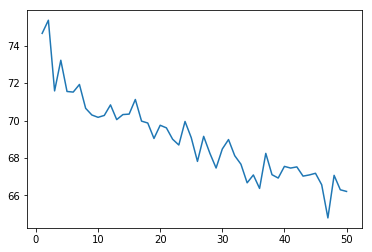

In [357]:
plt.plot(range(1, M + 1), errors)
plt.show()

In [358]:
def prediction(rank):
    pred = sigmoid(np.dot(Ws[rank-1],Hs[rank-1]))
    plt.imshow(pred, cmap='bwr')  
    plt.title('Predicted Data with Rank {}'.format(rank))
    plt.show()

interact(prediction, rank = (1, 50, 1));

interactive(children=(IntSlider(value=25, description='rank', max=50, min=1), Output()), _dom_classes=('widget…

Plot error vs estimation rank.

Now compute error for both changing rank( 1 to M) and max_iter(5000-20000). Plot it as a heatmap. You can use the plotting code below.

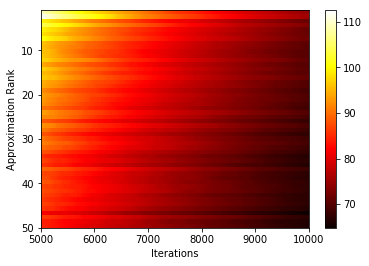

In [359]:
plt.imshow(errors_list, cmap='hot', interpolation='nearest', extent=[5000,10000,M,1], aspect='auto')
plt.xlabel('Iterations')
plt.ylabel('Approximation Rank')
plt.colorbar()
plt.show()

Now analyze the effect of varying the hidden element count(set your own limits) and approximation rank

In [364]:
M, N = original_matrix.shape
BATCH_M = 1
BATCH_N = N
if BATCH_M > M:
    BATCH_M = M
if BATCH_N > N:
    BATCH_N = N
# Compute error for varying estimation ranks from 1 to M
errors_mask_full = []
for rank in range(1, M + 1):
    errors_mask = []
    for mask_count in range(2, 11):
        mask = generate_mask(M, mask_count)
        Mask = mask.copy()
        Mask[mask != True] = False
        W, H, error, error_list = sgd(original_matrix, Mask, rank, BATCH_M, BATCH_N, MAX_ITER=5000, eta=0.005, nu=0.1)
        errors_mask.append(error)
    errors_mask_full.append(errors_mask)

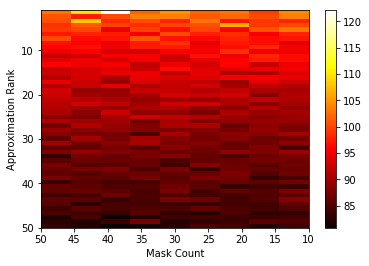

In [366]:
plt.imshow(errors_mask_full, cmap='hot', interpolation='nearest', extent=[100/2,100/10,M,1], aspect='auto')
plt.xlabel('Mask Count')
plt.ylabel('Approximation Rank')
plt.colorbar()
plt.show()

# PyTorch

Now implement BGD and SGD using PyTorch and generate the same plots.

In [302]:
import torch as tc
from torch.autograd import Variable

\begin{eqnarray}
\log p(Y |W, H ) &=& \sum_j \sum_{i} M(i,j) Y(i,j) \left(\sum_k W(i,k) H(k,j)\right)  - \sum_j \sum_{i} M(i,j) \log\left( 1+ \exp\left(\sum_k W(i,k) H(k,j)\right)\right) 
\end{eqnarray}

In [309]:
def sigmoid_tc(t):
    return 1./(1+tc.exp(-t))

def likelihood_tc(XM, Mask, W, H):
    return tc.sum(XM * tc.matmul(W, H) - Mask * tc.log(1 + tc.exp(tc.matmul(W, H))))


In [310]:
XM = original_matrix.copy()
mask = generate_mask(M)
Mask = mask.copy()
Mask[mask != True] = False
XM[Mask==False] = 0

XM_tc = torch.Tensor(XM)
Mask_tc = torch.Tensor(Mask)

In [338]:
def sgd_tc(original_matrix, Mask, K, MAX_ITER=1000, eta=0.005, nu=0.1):
    error_tc_list = []
    M, N = original_matrix.shape
    W_tc = Variable(torch.Tensor(np.random.randn(M,K)), requires_grad=True)
    H_tc = Variable(torch.Tensor(np.random.randn(K,N)), requires_grad=True)
    
    opt = torch.optim.SGD([W_tc, H_tc], lr=eta, weight_decay=nu)
    
    for epoch in range(MAX_ITER): 
        opt.zero_grad()
        E_tc = -likelihood_tc(XM_tc, Mask_tc, W_tc, H_tc)
        E_tc.backward()

        opt.step()
        if epoch > 250:
            error_tc_list.append(float(E_tc.detach().numpy()))
    
    error_tc = float(E_tc.detach().numpy())
    return W_tc, H_tc, error_tc, error_tc_list

In [339]:
random.seed(10)

# Compute error for varying estimation ranks from 1 to M
errors_tc_list = []
errors_tc = []
W_tcs = []
H_tcs = []
for rank in range(1, M + 1):
    W_tc, H_tc, error_tc, error_tc_list = sgd_tc(original_matrix, Mask, rank, MAX_ITER=1000, eta=0.005, nu=0.1)
    errors_tc_list.append(error_tc_list)
    errors_tc.append(error_tc)
    W_tcs.append(W_tc)
    H_tcs.append(H_tc)

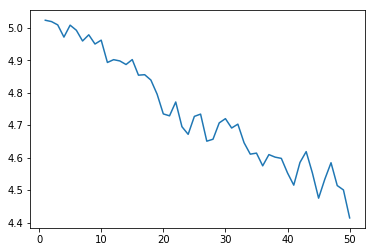

In [340]:
plt.plot(range(1, M + 1), errors_tc)
plt.show()

In [341]:
def prediction_tc(rank):
    pred = sigmoid_tc(tc.matmul(W_tcs[rank-1],H_tcs[rank-1]))
    pred = pred.detach().numpy()
    plt.imshow(pred, cmap='bwr')  
    plt.title('Predicted Data with Rank {}'.format(rank))
    plt.show()

interact(prediction_tc, rank = (1, 50, 1));

interactive(children=(IntSlider(value=25, description='rank', max=50, min=1), Output()), _dom_classes=('widget…

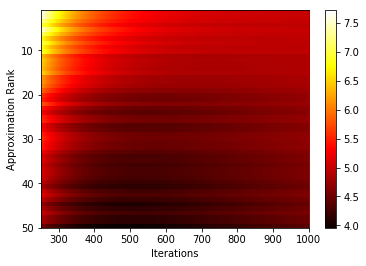

In [342]:
plt.imshow(errors_tc_list, cmap='hot', interpolation='nearest', extent=[250,1000,M,1], aspect='auto')
plt.xlabel('Iterations')
plt.ylabel('Approximation Rank')
plt.colorbar()
plt.show()

In [343]:
errors_tc_mask_full = []
for rank in range(1, M + 1):
    errors_tc_mask = []
    for mask_count in range(2, 11):
        mask = generate_mask(M, mask_count)
        Mask = mask.copy()
        Mask[mask != True] = False
        W_tc, H_tc, error_tc, error_tc_list = sgd_tc(original_matrix, Mask, rank, MAX_ITER=500, eta=0.005, nu=0.1)
        errors_tc_mask.append(error_tc)
    errors_tc_mask_full.append(errors_tc_mask)

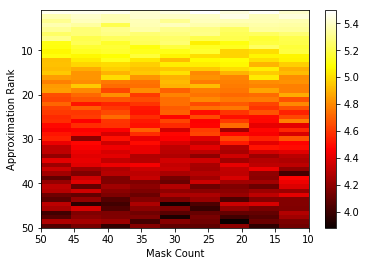

In [367]:
plt.imshow(errors_tc_mask_full, cmap='hot', interpolation='nearest', extent=[100/2,100/10,M,1], aspect='auto')
plt.xlabel('Mask Count')
plt.ylabel('Approximation Rank')
plt.colorbar()
plt.show()